# Similarity-based Character Word Embeddings for Chinese

The Association for Computational Linguistics (ACL) is the premier international scientific and professional society for people working on computational problems involving human language, a field often referred to as either computational linguistics or natural language processing (NLP). In mid-summer 2016, San Diego was chosen for the annual ACL conference where papers are submitted and evaluated. As a new San Diego native, I felt obligated to read one of the [accepted 2016 ACL papers](http://www.aclweb.org/anthology/N16-1119) gauging the effectiveness of exploited Chinese characters. Given that this is my first stab at learning the Chinese language, what could possibly go wrong?(*Shrugs*) My goal is to demonstrate how characters and words associated to them can change the conversation, if not used correctly. 

The idea behind this [paper](http://www.aclweb.org/anthology/N16-1119) is to show how jointly learned character and word embeddings can capture semantic contribution of characters to words using a similarity-based method. In the Chinese language, characters and words have different part-of-speech labels (e.g. noun, verb, etc.) and yet express the same meaning. Further, characters carry more ambiguity weight than words. To address this issue, the paper proposes multi-prototype character embeddings where different meanings of characters will be represented by different embeddings. Below, are some experiments to show the results.

### Data description

The paper investigates the characters "道" and "光" defined as "scenery" and "speak/say" using a test data set of highly ambiguous characters along with words that share the same meaning. In contrast, I will choose the character "落" defined by Google Translate as "drop" with it's associated words in this same data set. I printed the data set to show the disambiguation column which numerically labels the meaning importance of each word to the character "落".

In [1]:
import pandas as pd
import codecs
import re


def loadTestData(File):
    f = codecs.open(File, "r", "utf-8") 
    data = []
    for line in f:
        columns = re.split('\s+', line)
        data.append(columns)
    return data

df = pd.DataFrame(loadTestData('data/chardisamdata'))
df.drop(df.columns[[2]], axis=1, inplace=True)
df.columns = ['words', 'disamb_labels']
df.iloc[289:328,:].head(15)

,words,disamb_labels
289,落,
290,部落,3
291,坐落,3
292,降落,1
293,击落,1
294,衰落,2
295,村落,3
296,聚落,3
297,脱落,1
298,落地,1


### Loading character & word embedding models

When training the embedding model, the result is two 100-dimensional vector representations of Chinese characters and words. To train the model, I used the [Wikipedia data dump](http://download.wikipedia.com/zhwiki/) as suggested in the paper. Behind the scenes, I cleaned it up by removing all numbers, special characters, stop-words, and non-Chinese letters plus word segementation using a [Java implementation of a Chinese Lexical Analysis System](https://github.com/NLPchina/ansj_seg) (fun fact: it processes 1 million words per second with 96% accuracy for this task). I also used all of the models' default hyper-parameters except when enabling the multi-prototype method  (SCWE+M); the model's source code can be viewed and cloned from [SCWE](https://github.com/JianXu123/SCWE.git). This model's signature method is actually a compositional and similarity word enhancement from previous research done on character disambiguation (See [CWE](https://github.com/Leonard-Xu/CWE.git)).

In [2]:
import numpy as np

def loadCharModel(File):
    print("Loading Model")
    f = codecs.open(File,'r', 'utf-8')
    model = {}
    for line in f:
        splitLine = line.split()
        word, pos = splitLine[0:2]
        embedding = np.array([float(val) for val in splitLine[2:]])
        model[(word, pos)] =  embedding
    print("Done.",len(model)," characters loaded!")
    return model

scweChars = loadCharModel('models/char.txt')

Loading Model
Done. 83609  characters loaded!


Beautiful! The character model is loaded in with part-of-speech (pos) tags that help distinguish between the character meanings. I found a great guide to Chinese pos tags on [Huawei developers site](http://developer.huawei.com/ict/en/doc/en_sm_opg_c11/index.html/uap/opg/smartminer/opg/smartminer_opg_00704). Below, I printed the vector representation for character word and pos tag 'b', which is indicating an object feature or category per the pos tag guide.

In [6]:
print(scweChars[u'落', 'b'])

[  9.25000000e-04   2.10900000e-03   4.91900000e-03  -1.53600000e-03
  -3.13700000e-03  -4.70000000e-03  -1.70000000e-05   3.88700000e-03
   2.65500000e-03  -2.47500000e-03   4.66600000e-03   2.79600000e-03
   3.45600000e-03   8.14000000e-04   3.74000000e-04  -1.52700000e-03
  -3.07600000e-03  -3.01000000e-04   1.01500000e-03  -3.30100000e-03
   3.21400000e-03   1.21100000e-03   2.99300000e-03  -4.24500000e-03
   4.98200000e-03   4.88100000e-03  -4.78500000e-03  -3.57800000e-03
  -2.61500000e-03   2.74000000e-03  -9.12000000e-04   1.98100000e-03
  -1.92100000e-03  -6.79000000e-04  -1.48300000e-03  -1.78500000e-03
  -2.78000000e-03   1.65300000e-03  -9.10000000e-05   3.40300000e-03
  -2.53500000e-03  -7.32000000e-04   2.17100000e-03  -1.67200000e-03
   3.96900000e-03   4.19800000e-03  -3.29300000e-03  -3.72900000e-03
   4.39000000e-03   9.73000000e-04  -2.57400000e-03   3.01200000e-03
  -1.11800000e-03  -3.37400000e-03   7.32000000e-04  -3.16600000e-03
   1.04000000e-04   6.86000000e-04

In [3]:
def loadWordModel(File):
    print("Loading Model")
    f = codecs.open(File,'r', 'utf-8')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] =  embedding
    print("Done.",len(model)," words loaded!")
    return model

scweWords = loadWordModel('models/word.txt')

Loading Model
Done. 236575  words loaded!


### Visualizing embeddings

Now that the two models are loaded in, I will have to do some housekeeping and prepare for analysis. First, in the character model I will track down all the pos tags conncected to the character "落" and store it in a list. Next, I will use list comprehension to extract the embeddings from the newly created list. The same will occur for the words in the test data set. Finally, to visualize the embeddings, I will have to extend the list of embeddings and the list of character and words using the extend function. I printed the words to display what that looks like.

In [20]:
addW = pd.DataFrame({'words':[(u'落', i) for _, i in scweChars][4:7]}) # characters with pos labels
addDis = pd.DataFrame({'disamb_labels': [2, 3, 1]}) # manually label characters to disambiguate and to match words in test set

add = addW.join(addDis)
tester = df.loc[df['words'].isin([u'落石', u'落日', u'没落', u'沦落', u'村落', u'部落'])] # words to plot


char_list = add["words"].tolist() # character list
word_list = tester["words"].tolist() # word list 

testEmb_char = [scweChars[i] for i in char_list] # character embeddings
testEmb_word = [scweWords[i] for i in word_list] # word embeddings


testEmb_char.extend(testEmb_word) # extended character list with word list
char_list.extend(word_list) # extended character embeddings with word embeddings
print(char_list)

test = pd.concat([add, tester], ignore_index=True)
test_labels = pd.to_numeric(test["disamb_labels"]).tolist() # label list 

[('落', 'm'), ('落', 's'), ('落', 'b'), '部落', '村落', '没落', '沦落', '落日', '落石']


In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Since I am dealing with high dimensionality in the now extended embedding model (character & word), I will use principal component analysis (PCA) to visualize the closeness each word, from the test data set, is to the multi-contexted character "落" and also project the embeddings down from 100 to 2 dimensions.

## 2-D

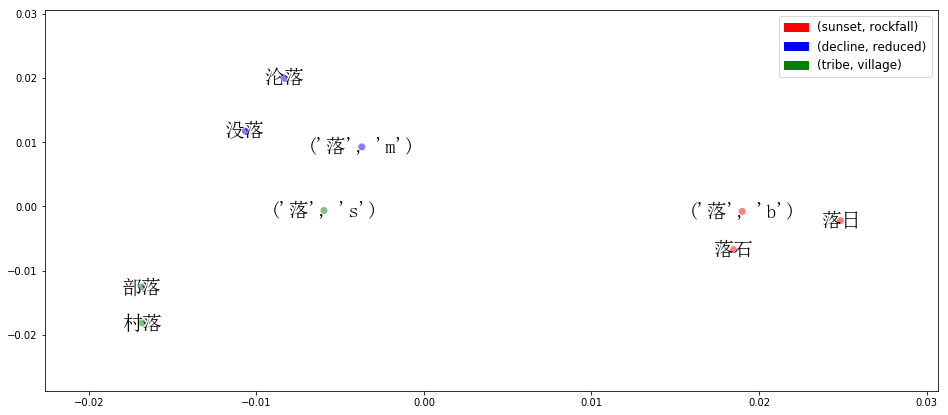

In [22]:
from sklearn.decomposition import PCA
from matplotlib.font_manager import FontProperties

fontP = FontProperties(fname = '../tmp/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/simsun.ttc')
fontP.set_family('SimHei')
fontP.set_size(20)

def plot_PCA(test_data, test_labels, words):
    pca = PCA(2)
    vector_map = pca.fit_transform(test_data)
    colors = ['red', 'blue', 'green']
    plt.scatter(vector_map[:, 0], vector_map[:, 1], c=test_labels, 
                           cmap=matplotlib.colors.ListedColormap(colors))
    for i, m in enumerate(vector_map):
        plt.text(m[0], m[1], words[i], ha='center', va='center', fontproperties = fontP,
                 bbox=dict(facecolor='white', alpha=0.5,lw=0))
        red_patch = mpatches.Patch(color='red', label='(sunset, rockfall)')
        blue_patch = mpatches.Patch(color='blue', label='(decline, reduced)')
        green_patch = mpatches.Patch(color='green', label='(tribe, village)')
        plt.legend(handles=[red_patch, blue_patch, green_patch], prop={'size': 12})

f, ax = plt.subplots(1, figsize = (16, 7))
plot_PCA(testEmb_char, test_labels, char_list)
plt.show()

As shown above, I took 3 different meanings of the Chinese character "落" and 2 of its top-related words to visualize the character and word embedding models. The legend's order arrangement denotes the character's meaning importance, top to bottom. It also provides the meaning of the plotted words as an indicator of the character's context.

Again, let's observe the character color-coded in red ('落', 'b') plus the words "落日" and "落石" in the plot. All three of their meanings are related to an object feature such as "fall", which is why they're gathered together in the emedding space. 

Let's bump it up a dimension!

## 3-D 

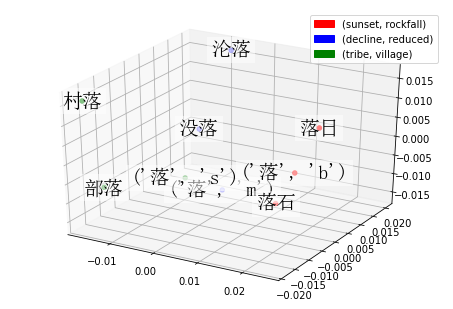

In [92]:
from mpl_toolkits.mplot3d import Axes3D

def plot_PCA_3D(test_data, test_labels, words):
    pca = PCA(3)
    f = plt.figure()
    ax = Axes3D(f)
    vector_map = pca.fit_transform(test_data)
    colors = ['red', 'blue', 'green']
    ax.scatter(vector_map[:, 0], vector_map[:, 1], vector_map[:, 2], c=test_labels, 
                           cmap=matplotlib.colors.ListedColormap(colors))
    for i, m in enumerate(vector_map):
        ax.text(m[0], m[1],m[2], words[i], ha='center', va='center', fontproperties = fontP, 
                bbox=dict(facecolor='white', alpha=0.5, lw=0))
        red_patch = mpatches.Patch(color='red', label='(sunset, rockfall)')
        blue_patch = mpatches.Patch(color='blue', label='(decline, reduced)')
        green_patch = mpatches.Patch(color='green', label='(tribe, village)')
        plt.legend(handles=[red_patch, blue_patch, green_patch], prop={'size': 10})


plot_PCA_3D(testEmb_char, test_labels, char_list)
plt.show()

### Evaluating accuracy on character disambiguation

This paper used an [online Xinhua Dictionary](http://xh.5156edu.com/) as a standard to disambiguate words that contained highly ambiguous characters. Each word, in the test data set, was labeled a number denoting the meaning importance of the target character "落". Below, I will use the K-Nearest Neighbors (KNN) model to classify the meaning lables and evaluate its accuracy score.

In [13]:
test_words = df.iloc[290:328,:]
test = pd.concat([add, test_words], ignore_index=True)

word_list = test_words["words"].tolist() # word list

testEmb_word = [scweWords[i] for i in word_list] # word embeddings

testEmb_char.extend(testEmb_word) # extend the same character embeddings with more word embeddings

test_labels = pd.to_numeric(test["disamb_labels"]).tolist() # label list 

In the previous code block, I manually labeled the the character importance based on results from PCA and the related words defined in the [online dictionary](http://xh.5156edu.com/) (See query: 落).

The classifier's accuracy score is high at 88% and seemingly on par with the results in the paper. The paper actually resulted in a 91% accuracy score, and that's with lambda fine tuning. Remember, I mentioned the default hyper-parameters were used to train the model. In other words, the model does fairly well with disambiguating similar characters without any fine tuning.

In [22]:
from sklearn import neighbors
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(testEmb_char, test_labels , test_size=0.19, random_state=40)

clf = neighbors.KNeighborsClassifier(4, algorithm = 'auto', n_jobs=-1) # classifer
clf.fit(X_train, y_train)

print('Testing Score: %.3f' % (clf.score(X_test, y_test)))

Testing Score: 0.875


I will also show how close each word embedding is to a given character embedding using KNN with a consine distance metric. This approach adds as another reference to the meaning contribution in the embedding space. I used all the pre-trained words including the character, '落' --- fallen object.

In [22]:
charVec_b = scweChars[u'落', 'b'] # run the character & pos list through the model for embeddings
words = [i for i in scweWords][2:] # list the words in the modeled data set
wordVec = [scweWords[i] for i in words] # run words through word model for embeddings

wordVec.append(charVec_b) # append the character vector list to the word vector list 
words.extend([(u'落', 'b')]) # extend the character & pos list to the word list 


word_id = {w:i for i, w in enumerate(words)}
id_word = dict(enumerate(words))

In [23]:
from operator import itemgetter

k=7

def knn(word, embeddings, word_id, id_word):
    word_index = word_id[word]
    e = embeddings[word_index]
    distances = (((embeddings - e) ** 2).sum(axis=1) ** 0.5) # cosine distance metric
    sorted_distances = sorted(enumerate(distances), key=itemgetter(1))
    indices, distances = zip(*sorted_distances[:k])
    neighbors = [id_word[idx] for idx in indices]
    for i, (word, distance) in enumerate(zip(neighbors, distances)):
        print(i, '\t', word, '\t', distance) 
        
knn((u'落', 'b'), wordVec, word_id, id_word) # ranked 1st in meaning importance

0 	 ('落', 'b') 	 0.0
1 	 斯巴達克思 	 0.0124823900356
2 	 特技飞行 	 0.0143404391843
3 	 敏迷龍屬 	 0.014834326375
4 	 军医学院 	 0.0151471503921
5 	 洪承畴 	 0.016492237659
6 	 高青縣 	 0.0171204643337


The results makes sense from a Wikipedia standpoint. The closes associated word to this character is defined as "Spartacus", which maybe contributed towards the TV series episode *Spartacus: The Fallen*.

### Use cases for word embeddings 

There are a few applications where word embeddings would serve a purpose. One would be in the social media space, where a retailer could scrape posts from a site like Twitter (for free) to determine brand popularity in a brand awareness analysis. Or if you want to improve a biomedical search engine to query closely associated words in documents from your database for more in-depth search results.

The NLP world is growing really fast and has fascinating work. This is just one of many [papers accepted](http://naacl.org/naacl-hlt-2016/accepted_papers.html) in 2016's ACL where students and researchers showcase an improvement to a problem already addressed in previous research. Like others, I am a fan of research efforts into how information is distributed in a more education-friendly and resourceful way.

This might be my first stab at NLP and Chinese, but it won't be my last!